# Sibyl evaluation results
Results of the evaluation by Sibyl team. Data available here: https://github.com/sibyl-team/ViraTrace-example

In [1]:
import sys
sys.path.append("InfectionModel/contagion_sim/")

In [2]:
import numpy as np
import pandas as pd
import tqdm

from multisim_model_evaluation import MultisimModelEvaluation

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
contacts = pd.read_csv("contacts_t_12.csv.gz",index_col=0)

/opt/anaconda3/envs/bigdatalab_201911/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
observations = pd.read_csv("observ_t_12.csv.gz",index_col=0)

### Description

We have 12 days of contacts and a variable number of observations up until day 11

We want to obtain the risk prediction for the nodes on day 12

In [6]:
observations[observations.t == 7]

,i,state,t
0,3032,1,7
1,6865,0,7
2,2868,0,7
3,518,0,7
4,7375,0,7
5,7441,0,7
6,2377,0,7
7,3834,0,7
8,9320,0,7
9,3747,0,7


In [7]:
contacts

,i,j,t
0,0,3,0
1,0,2,0
2,0,1,0
3,0,1540,0
4,0,7583,0
...,...,...,...
1320789,9999,2726,12
1320790,9999,7050,12
1320791,9999,6990,12
1320792,9999,9242,12


In [8]:
contacts.rename(columns={'i': 'a', 'j': 'b'}, inplace=True)

In [9]:
observations.rename(columns={'i': 'a'}, inplace=True)

In [10]:
N = max(contacts['a'])+1
n_days = max(contacts['t'])
INFECTION_P = 0.02
INFECTED_P = 1/N
RECOVERY_T = 50

N_SIMS = 1000

SEED=4

edge_batch_gen = ((t, contacts[contacts.t == t]) for t in range(0, contacts.t.max()))

In [11]:
np.random.seed(SEED)
model = MultisimModelEvaluation(N, n_days, N_SIMS, edge_batch_gen, observations,
                                INFECTION_P, INFECTED_P, RECOVERY_T, None, recovery_dist='geometric',
                                directed_edges=True, tqdm=tqdm.tqdm)

In [12]:
model.run_sim()

Starting simulation...: 100%|██████████| 12/12 [00:36<00:00,  3.07s/it]


In [13]:
risk = pd.Series(model.I.sum(axis=1)).sort_values(ascending=False)
risk = (risk / risk.max())
risk.head(20)

9438    1.000
8182    1.000
1085    0.984
5647    0.980
8345    0.966
1839    0.966
4698    0.948
6118    0.942
3032    0.924
6688    0.921
3033    0.094
6690    0.086
6692    0.085
6689    0.082
6693    0.075
4699    0.070
1838    0.060
1837    0.055
2773    0.048
7940    0.044
dtype: float64

In [14]:
def get_risk(model):
    risk = pd.Series(model.I.sum(axis=1)).sort_values(ascending=False)
    risk = (risk / risk.max())
    return risk

In [15]:
risk.to_csv("nodes_risk_original_model.csv")

/opt/anaconda3/envs/bigdatalab_201911/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Faster version

In [16]:
from sibyl_model_eval import FasterEvaluationModel

In [17]:
np.random.seed(SEED)
edge_batch_gen = ((t, contacts[contacts.t == t]) for t in range(0, contacts.t.max()))

our_model = FasterEvaluationModel(N, n_days, N_SIMS, edge_batch_gen, observations,
                                INFECTION_P, INFECTED_P, RECOVERY_T, None, recovery_dist='geometric',
                                directed_edges=True, tqdm=tqdm.tqdm)

In [18]:
our_model.run_sim()

Starting simulation...: 100%|██████████| 12/12 [00:15<00:00,  1.28s/it]


In [19]:
our_risk = get_risk(our_model)

In [20]:
np.all(model.I == our_model.I), np.all(model.S == our_model.S)

(True, True)

## Old model - MultisimRank

In [21]:
from continuous_fast import MultisimRankModel
mu = 1/RECOVERY_T

np.random.seed(SEED)
model_ours = MultisimRankModel(N, INFECTION_P, mu, n_days, N_SIMS, contacts_directed=True, tqdm=tqdm.tqdm)

### Add contacts
Replacing the index in the contacts

In [22]:
for day, con_day  in contacts.groupby("t"):
    model_ours.add_contacts_day(day, con_day.reset_index(drop=True))

### Add observations

Add the observations for each day, formatting them for ViraTrace

In [23]:
for day, observ_day in observations.groupby("t"):
    #print(observ_day)
    positive_test_idx = observ_day[observ_day.state == 1]["a"]
    print(positive_test_idx.values)
    
    negative_test_idx = observ_day[observ_day.state == 0]["a"]
    
    tested_positive = np.full(N,False)
    if len(positive_test_idx) > 0:
        tested_positive[positive_test_idx.values] = True
    tested_negative = np.full(N,False)
    if len(negative_test_idx) > 0:
        tested_negative[negative_test_idx.values] = True

    model_ours.set_daily_observations(day, tested_negative, tested_positive)
    print(day)


[3032]
7
[4698 6688 6118]
8
[8345 1839]
9
[5647 1085]
10
[9438 8182]
Propagation
11


### Launch simulations
Since we have no observations of the initial condition, we have to use a prior probability for each node to be infected at time 0

In [24]:
model_ours.start_sim(INFECTED_P)

Starting simulation...:   0%|          | 0/12 [00:00<?, ?it/s]

Setting random initial condition


Day:12	S:99%	I:0%	R:0%: 100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


23941


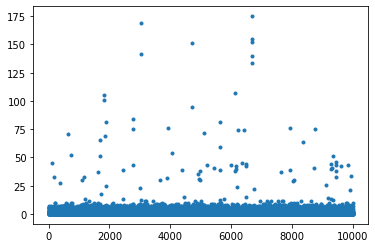

In [25]:
import matplotlib.pyplot as plt
re = (model.I != model_ours.I)
print(re.sum())
plt.plot(re.sum(1),".")

### Calculate risk

In [26]:
def get_risk_MultiSimRank(model):
    risk = pd.Series(model.I.sum(1))

    risk = (risk / risk.max()).sort_values()

    risk.sort_values(ascending=False, inplace=True)
    return risk

In [27]:
risk_ours = get_risk_MultiSimRank(model_ours)

In [28]:
risk_ours.head(20)

9438    1.000
8182    1.000
1085    0.984
5647    0.981
8345    0.970
1839    0.959
6118    0.949
4698    0.947
6688    0.929
3032    0.922
6692    0.096
4699    0.095
3033    0.089
6689    0.080
6690    0.079
6693    0.077
1838    0.059
1837    0.052
3915    0.048
1904    0.043
dtype: float64

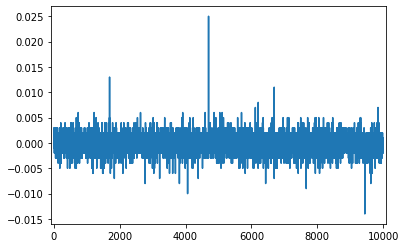

In [29]:
(risk_ours - risk).plot(xlim=(-80,10080))
plt.savefig("risk_comparison.png",bbox_inches="tight")